# Lab 12: Transformers, Speech Recognition

#### st121720 
#### Pranisaa Charnparttaravanit
This lab consists of 3 parts which are testing transform on my own text data and testing DeepSoeech2 on my own audio data. <br>
The testing text was taken from wikipedia (about transformer) and the audio (nlp_for_developers_transformers) was taken from youtube whose video was converted to mp3. 

TASK1 RESULT

| End of training | test loss  5.73 | test ppl   306.45

TASK2 RESULT

Test set: Average loss: 3.9351, Average CER: 0.698718 Average WER: 1.0000

Note: CUDA was full when i was doing the lab, the weight used to evalate the model (TASK2) was taken from Krittin. He was able to train his model on gourami. 


#### TASK1 After training, test the transformer on some data (text) you provide yourself

## Transformer With Torchtext

In [12]:
from comet_ml import Experiment

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

### Load data

In [13]:
import io
import torch
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line in train_iter:
    counter.update(tokenizer(line))
vocab = Vocab(counter)

def data_process(raw_text_iter):
    data = [torch.tensor([vocab[token] for token in tokenizer(item)],
                       dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) 
print("Configured device: ", device)

def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    print(data)
    return data.to(device)

batch_size = 20
eval_batch_size = 10

Configured device:  cuda:1


#### Load my own text

In [15]:
data = "Before the introduction of Transformers, most state-of-the-art NLP systems relied on gated recurrent neural networks (RNNs), such as LSTMs and gated recurrent units (GRUs), with added attention mechanisms. The Transformer built on these attention technologies without using an RNN structure, highlighting the fact that the attention mechanisms alone, without recurrent sequential processing, are powerful enough to achieve the performance of RNNs with attention."
data = data.split(" ")
print(data)
data = data_process(data)

train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(data, eval_batch_size)

['Before', 'the', 'introduction', 'of', 'Transformers,', 'most', 'state-of-the-art', 'NLP', 'systems', 'relied', 'on', 'gated', 'recurrent', 'neural', 'networks', '(RNNs),', 'such', 'as', 'LSTMs', 'and', 'gated', 'recurrent', 'units', '(GRUs),', 'with', 'added', 'attention', 'mechanisms.', 'The', 'Transformer', 'built', 'on', 'these', 'attention', 'technologies', 'without', 'using', 'an', 'RNN', 'structure,', 'highlighting', 'the', 'fact', 'that', 'the', 'attention', 'mechanisms', 'alone,', 'without', 'recurrent', 'sequential', 'processing,', 'are', 'powerful', 'enough', 'to', 'achieve', 'the', 'performance', 'of', 'RNNs', 'with', 'attention.']
tensor([[   10,     2,  3732,  ...,     2,   324,   762],
        [   60,     0,   192,  ...,  6577,     7,     5],
        [  565,  3913,    24,  ..., 12262,     9,   593],
        ...,
        [ 2069,   306,  2859,  ...,     5,    78,  1945],
        [    2,  3573,  2929,  ...,   423,    65, 17236],
        [   35,     4,  1301,  ...,    15,  

### Generate input and target sequences

In [16]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

### Initialize the model

Next let's initialize the model:

In [17]:
ntokens = len(vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

### Run the model

Now let's train it. Note that in the language modeling
community, exp(negative log likelihood) is called "Perplexity"
and abbreviated PPL.

In [18]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

In [43]:
best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 11.85 | loss  7.55 | ppl  1907.09
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 11.37 | loss  6.61 | ppl   740.24
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 12.41 | loss  6.24 | ppl   511.99
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 11.41 | loss  6.13 | ppl   459.48
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 11.29 | loss  6.03 | ppl   417.26
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 11.28 | loss  6.01 | ppl   405.73
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 11.23 | loss  5.98 | ppl   395.41
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 11.13 | loss  5.97 | ppl   392.43
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 11.32 | loss  5.88 | ppl   357.37
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 12.14 | loss  5.86 | ppl   352.09
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 11.31 | loss  5.74 | ppl   311.22
| epoch   1 |  2400/ 

### Evaluate the model with test data

In [45]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  5.73 | test ppl   306.45


#### TASK2 After training, test the two models on some data (audio) you provide yourself
## End-to-end (Recurrent) Speech Recognition Model

In [19]:
import os
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [20]:
train_dataset = torchaudio.datasets.LIBRISPEECH("/root/work_dir/Github_rtml/Lab12/data/LibriSpeech", url="train-clean-100", download=False)
train_dataset = torchaudio.datasets.LIBRISPEECH("/root/work_dir/Github_rtml/Lab12/data/LibriSpeech", url="test-clean", download=False)

Sample dataset

<class 'torch.Tensor'>
16000
HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE
1089
134686
Shape of waveform: torch.Size([1, 166960])
Sample rate of waveform: 16000


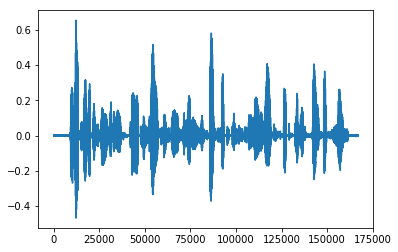

In [21]:
waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
print(type(waveform))
print(sample_rate)

print(utterance)

print(speaker_id)
print(chapter_id)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

ipd.Audio(waveform.numpy(), rate=sample_rate)

## Data Augmentation - SpecAugment
In PyTorch, you can use the torchaudio function FrequencyMasking to mask out the frequency dimension, and TimeMasking for the time dimension.

In [22]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

/usr/local/lib/python3.6/dist-packages/torchaudio/functional/functional.py:358: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.



Now that we have the data, we'll need to transform the audio into Mel Spectrograms, and map the character labels for each audio sample into integer labels:

In [23]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')

In [24]:
valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()

In [25]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

## Define the Model - Deep Speech 2

In [26]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

### Evaluation metrics

Here are implementations of the common evaluation metrics for speech recognition:

In [27]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

## Monitoring experiments using comet.ml

Comet.ml provides a platform that allows deep learning researchers to track, compare, explain, and optimize their experiments and models. Comet.ml has improved our productivity at AssemblyAI and we highly recommend using this platform for teams doing any sort of data science experiments. Comet.ml is super easy to set up. And works with just a few lines of code.


In [29]:
# To use comet.ml, which is kind of cool but requires an account and API key from them,
# go to comet.ml, create an account, create project, and create an API key. Then fill
# in the variables

comet_api_key = ''
project_name = ''
experiment_name = ''

# Initialize experiment object

experiment = Experiment(api_key=comet_api_key, project_name=project_name)
experiment.set_name(experiment_name)

# Later, you can track metrics in the cloud GUI. To log a loss:

# experiment.log_metric('loss', test_loss) #.item())

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: The given API key  is invalid, please check it against the dashboard. Your experiment would not be logged 
For more details, please refer to: https://www.comet.ml/docs/python-sdk/warnings-errors/


## Training function

In [30]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment):
    model.train()
    data_len = len(train_loader.dataset)
    with experiment.train():
        for batch_idx, _data in enumerate(train_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            optimizer.zero_grad()

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            loss.backward()

            experiment.log_metric('loss', loss.item(), step=iter_meter.get())
            experiment.log_metric('learning_rate', scheduler.get_lr(), step=iter_meter.get())

            optimizer.step()
            scheduler.step()
            iter_meter.step()
            if batch_idx % 100 == 0 or batch_idx == data_len:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(spectrograms), data_len,
                    100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, criterion, epoch, iter_meter, experiment):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with experiment.test():
        with torch.no_grad():
            for i, _data in enumerate(test_loader):
                spectrograms, labels, input_lengths, label_lengths = _data 
                spectrograms, labels = spectrograms.to(device), labels.to(device)

                output = model(spectrograms)  # (batch, time, n_class)
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0, 1) # (time, batch, n_class)

                loss = criterion(output, labels, input_lengths, label_lengths)
                test_loss += loss.item() / len(test_loader)

                decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    experiment.log_metric('test_loss', test_loss, step=iter_meter.get())
    experiment.log_metric('cer', avg_cer, step=iter_meter.get())
    experiment.log_metric('wer', avg_wer, step=iter_meter.get())

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))

## Picking the Right Optimizer and Scheduler - AdamW with Super Convergence

#### Define hyperparameters, loss function, dataloaders, models and optimizer

In [31]:
learning_rate=5e-4
batch_size=20
epochs=10

# experiment=Experiment(api_key='dummy_key', disabled=True)

hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

# experiment.log_parameters(hparams)

use_cuda = torch.cuda.is_available()

from chosen_gpu import get_freer_gpu
use_cuda = torch.device(get_freer_gpu()) 
print("Configured device: ", use_cuda)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=True,
                            collate_fn=lambda x: data_processing(x, 'train'),
                            **kwargs)
test_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            **kwargs)

model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
    ).to(device)

print(model)
print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=28).to(device)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], 
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=hparams['epochs'],
                                        anneal_strategy='linear')

Configured device:  cuda:0
SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (la

## Evaluating Your Speech Model

In [32]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

## Start training and evaluating on the test set

In [33]:
iter_meter = IterMeter()
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment)
    test(model, device, test_loader, criterion, epoch, iter_meter, experiment)

RuntimeError: CUDA out of memory. Tried to allocate 578.00 MiB (GPU 1; 10.76 GiB total capacity; 8.68 GiB already allocated; 542.56 MiB free; 9.12 GiB reserved in total by PyTorch)

#### Load my own audio

torch.Size([2, 14728298])
torch.Size([1, 440000])
44100


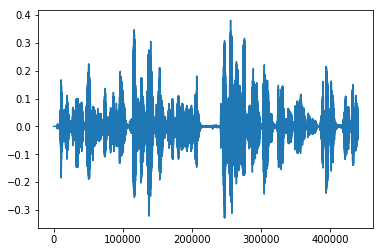

In [34]:
waveform_org, sample_rate = torchaudio.load('nlp_for_developers_transformers.mp3')
print(waveform_org.shape) # my audio has 2 channels i will make it 1

waveform = waveform_org[0][:440000].reshape(1,-1)
print(waveform.shape)
print(sample_rate)

plt.plot(waveform.t().numpy());

ipd.Audio(waveform.numpy(), rate=sample_rate)

In [42]:
utterance = "WHAT ARE THE TRANSFORMERS THAT YOU HEARD SO MUCH ABOUT HOW DO THEY WORK AND SHOULD YOU BE USING THEM WE WILL TALK ABOUT ALL THAT TODAY ON NLP FOR DEVELOPERS"

my_audio = (waveform, sample_rate, utterance, 103, 1240, 0) # make my input has the same format as the input data
print(my_audio)

my_audio_list = [my_audio]

my_processed_audio = data_processing(my_audio_list, data_type="valid")

my_loader = [my_processed_audio]

(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0277, -0.0303, -0.0324]]), 44100, 'WHAT ARE THE TRANSFORMERS THAT YOU HEARD SO MUCH ABOUT HOW DO THEY WORK AND SHOULD YOU BE USING THEM WE WILL TALK ABOUT ALL THAT TODAY ON NLP FOR DEVELOPERS', 103, 1240, 0)


In [43]:
model.load_state_dict(torch.load('weights/SpeechRecognitionModel_2.weight'))

<All keys matched successfully>

In [45]:
epochs = 1
iter_meter = IterMeter()
for epoch in range(1, epochs + 1):
    test(model, device, my_loader, criterion, epoch, iter_meter,experiment)


evaluating...
Test set: Average loss: 3.9351, Average CER: 0.698718 Average WER: 1.0000



## Homework

*Write an explanation of the steps that would be needed to adapt the PyTorch transformer to
the speech recognition task.*

To adapt PyTorch transformer to the speech recognition task, the model should include transcribing audio speech segments in to text which will be treated as a sequence-to-sequence problem, where the audio can be represented as a sequence of feature vectors and the text as a sequence of character or words.

First the audio speech must be transcribed into text which willl be used as our utterances and is to be converted into integers used in the transformer.

To process the audio features for the decoder, downsampling 1-d convolutional layers will be applied to obtain the laten speech representation. This representation will then be fed into the transforme consisting of TransformerEncoder and TransformerEncoderLayers.

As for the optimizer, and loss function, the same as the model above will be applied. 